In [13]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for Leaky ReLU
import torch.optim as optim

Upwind Scheme - CFL Number: 0.9980000000000001


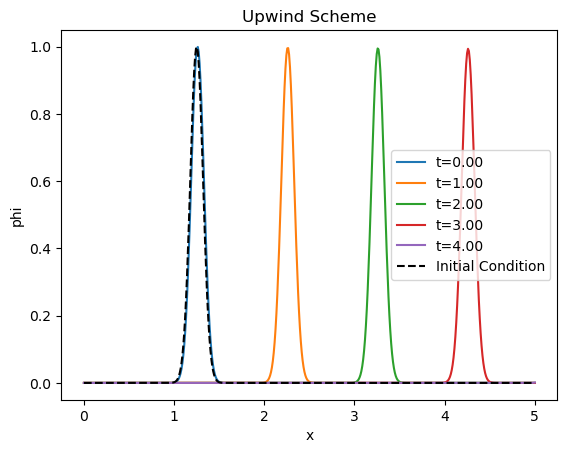

In [24]:
# Define parameters
nx = 500          # Number of spatial points
L = 5.0         # Domain length
dx = L / (nx - 1)  # Spatial resolution
dt = 0.01        # Time step (CFL < 1 for stability)
a = 1.0          # Advection speed
T = 5.0          # Total simulation time
Nt = int(T / dt) # Number of time steps

# For linear advection, CFL=1 is optimal, lower CFL will become more diffusive and dispersive (why?)
CFL = a * dt / dx
print(f"Upwind Scheme - CFL Number: {CFL}")

# Spatial grid
x = np.linspace(0, L, nx)

# Initial condition: Gaussian pulse
phi = np.exp(-((x - L/4) / 0.1) ** 2)

# Store initial condition for reference
phi_init = phi.copy()

# Upwind scheme (Stable)
phi_new = np.zeros_like(phi)

for n in range(Nt):
    # Apply Upwind update (first-order)
    phi_new[1:] = phi[1:] - CFL * (phi[1:] - phi[:-1])  # Forward in time, backward in space

    # Update the field
    phi[:] = phi_new[:]

    # Plot every few steps
    if n % 100 == 0:
        plt.plot(x, phi, label=f"t={n*dt:.2f}")

# Plot results
plt.plot(x, phi_init, 'k--', label="Initial Condition")
plt.legend()
plt.xlabel("x")
plt.ylabel("phi")
plt.title("Upwind Scheme")
plt.show()

In [71]:
# Parameters
nx = 500  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01 # Time step
a = 1.0   # Advection speed
T = 5.0   # Total simulation time
nt = int(T / dt)  # Number of time steps

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L/4) / 0.1) ** 2)

# Grid points
x = np.linspace(0, L, nx)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 25)  # Input: (x, t)
        self.fc2 = nn.Linear(25, 25)
        self.fc3 = nn.Linear(25, 25)
        self.fc4 = nn.Linear(25, 1)  # Output: u(x, t)

    # Relu gives weird results which have these straight lines.
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = F.tanh(self.fc1(inputs))
        out = F.tanh(self.fc2(out))
        out = F.tanh(self.fc3(out))
        out = self.fc4(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x)**2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true)**2)

for epoch in range(10000):
    optimizer.zero_grad()
    
    # Sample random collocation points
    num_samples = 300  
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32).reshape(-1, 1)
    
    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss = loss_pde + loss_ic
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 0.031628336757421494
Epoch 1000, Loss: 0.0217562485486269
Epoch 2000, Loss: 0.00821201503276825
Epoch 3000, Loss: 0.00039661972550675273
Epoch 4000, Loss: 0.00011502299457788467
Epoch 5000, Loss: 9.33695409912616e-05
Epoch 6000, Loss: 3.3363132388330996e-05
Epoch 7000, Loss: 1.6345567928510718e-05
Epoch 8000, Loss: 1.6190417227335274e-05
Epoch 9000, Loss: 2.0469500668696128e-05


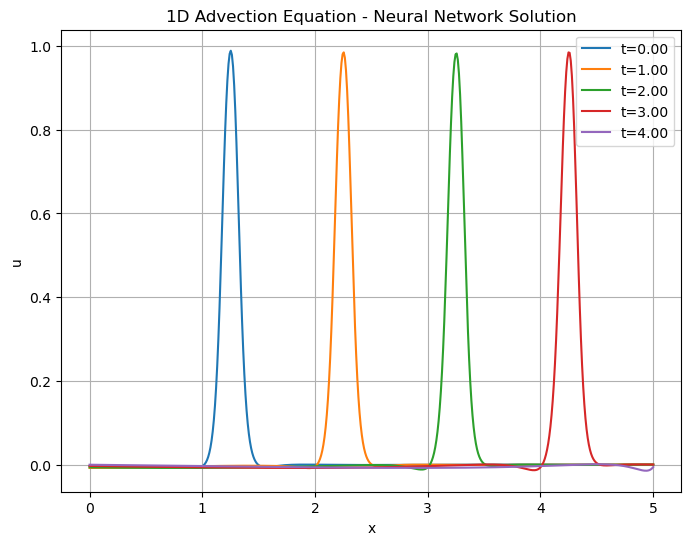

In [72]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(0, nt, 100):
    t_test = torch.full_like(x_test, n * dt) # Creates a vector with the same shape as x_test with a constant value equal to n*dt
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n*dt:.2f}")

plt.title('1D Advection Equation - Neural Network Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.show()

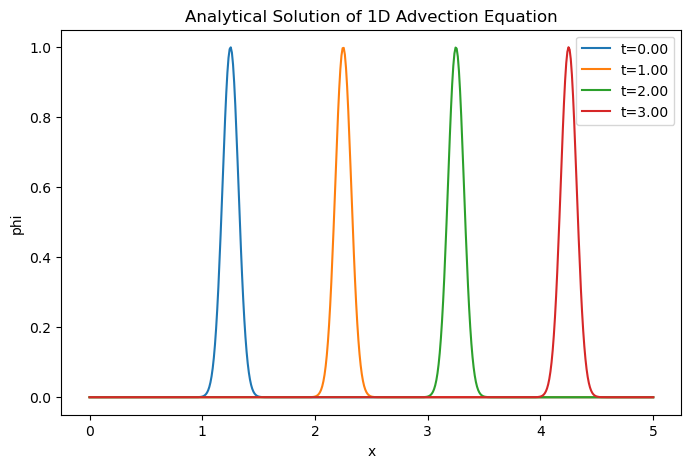

In [49]:
# Analytical solution
# Define parameters
nx = 500          # Number of spatial points
L = 5.0           # Domain length
dx = L / (nx - 1)  # Spatial resolution
dt = 0.01         # Time step
a = 1.0           # Advection speed
T = 5.0           # Total simulation time

# Spatial grid
x = np.linspace(0, L, nx)

# Initial condition: Gaussian pulse
phi_init = np.exp(-((x - L/4) / 0.1) ** 2)

# Times to plot
times = [0, 1.0, 2.0, 3.0]

# Plot analytical solutions at specified times
plt.figure(figsize=(8, 5))
for t in times:
    x_shifted = (x - a * t) % L  # Apply periodic boundary condition
    phi_analytical = np.exp(-((x_shifted - L/4) / 0.1) ** 2)
    plt.plot(x, phi_analytical, label=f"t={t:.2f}")

plt.legend()
plt.xlabel("x")
plt.ylabel("phi")
plt.title("Analytical Solution of 1D Advection Equation")
plt.show()
